# Generate RBS Recommendations

This notebook generates RBS recommendations based on the [dataset](https://github.com/synbiochem/opt-mva) provided by [paper](https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398). The goal is to find the best 6-base RBS sequence (-6 ~-12 base?) which gives the maximum translation initiation rate (TIR). 

The dataset has 56 arms with 113 data points, which each sequence is 13-base and the label is the TIR. We read the whole data as initialisation and recommend 100 arms to sample in the first round, which will be done in the biology experiment. So the 100 arms should be unique and sampled from the  whole possible arm space. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
group_one = df[:158].drop_duplicates(subset =['A', 'C'])
group_two = df[158:].drop_duplicates(subset =['A', 'C'])

print('group one length: ', len(group_one))
print('group two length: ', len(group_two))

group one length:  57
group two length:  56


In [5]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [6]:
data_one = np.asarray(normalize(group_one)[['A', 'C']])
data_two = np.asarray(normalize(group_two)[['A', 'C']])

## Regression

In [7]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, 
           #WD_shift_kernel_pw
          ]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               mixed_spectrum_kernel_pw: 'mspec',
               WD_kernel_pw: 'WD',
               WD_shift_kernel_pw: 'WDshift'}

train_scores = {}
test_scores = {}

data = data_two

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.15617211884490792
Test RMSE:  0.10888090120436832


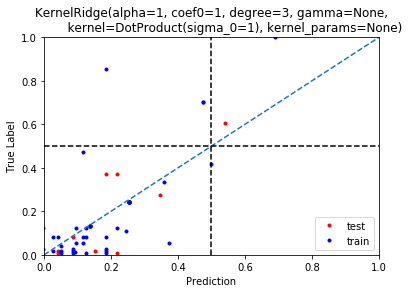

In [8]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_onehot_DP'] = train_score
test_scores['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.21219873681842552
Test RMSE:  0.1904042053240897


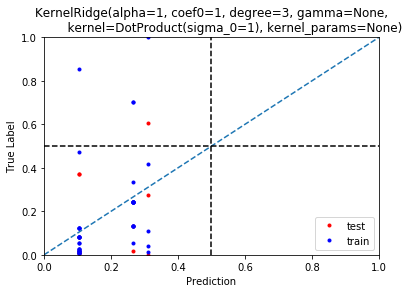

In [9]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_kmer_DP'] = train_score
test_scores['KR_kmer_DP'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.15124111201898544
Test RMSE:  0.13472408370575686


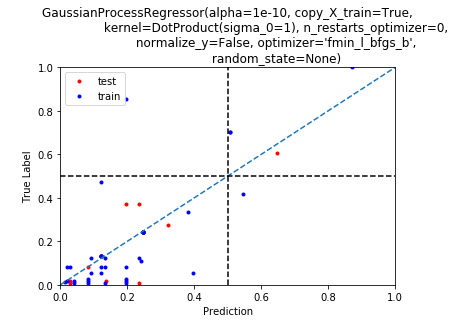

In [10]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_onehot_DP'] = train_score
test_scores['GPR_onehot_DP'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.21218469989908065
Test RMSE:  0.19082815118216698


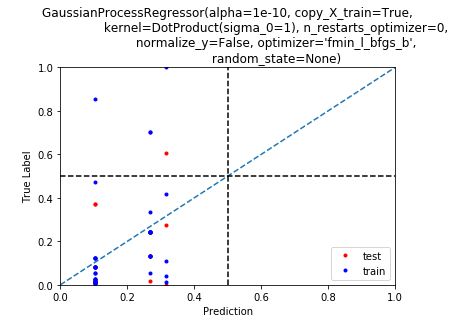

In [11]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_kmer_DP'] = train_score
test_scores['GPR_kmer_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7fc98831c2f0>,
            kernel_params=None)
Train RMSE:  0.13963261494257592
Test RMSE:  0.13021913132380636

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7fc98831c378>,
            kernel_params=None)
Train RMSE:  0.1509656752547973
Test RMSE:  0.11171148224742843

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7fc98831c400>,
            kernel_params=None)
Train RMSE:  0.1415920673231492
Test RMSE:  0.11874747904708292

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7fc98831c2f0>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train

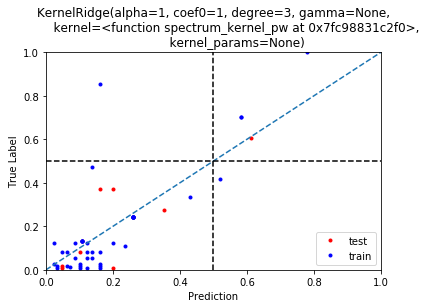

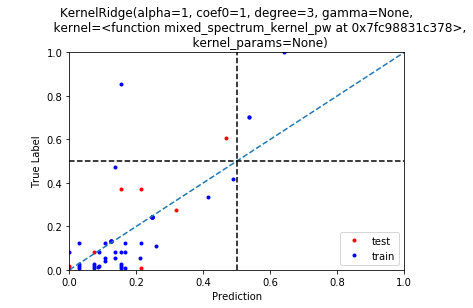

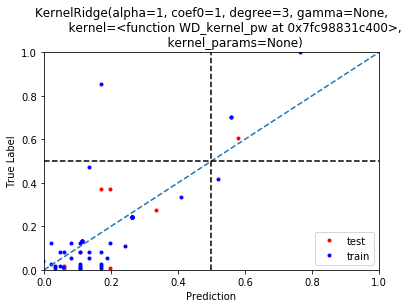

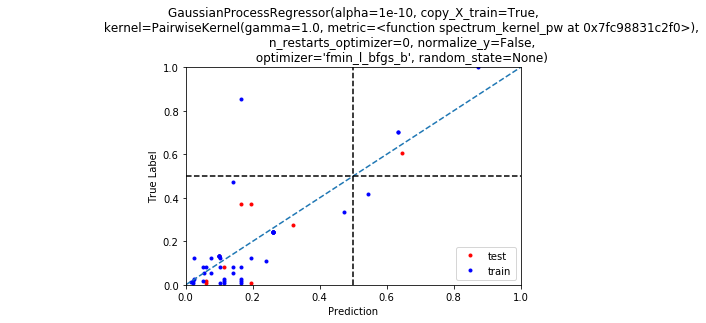

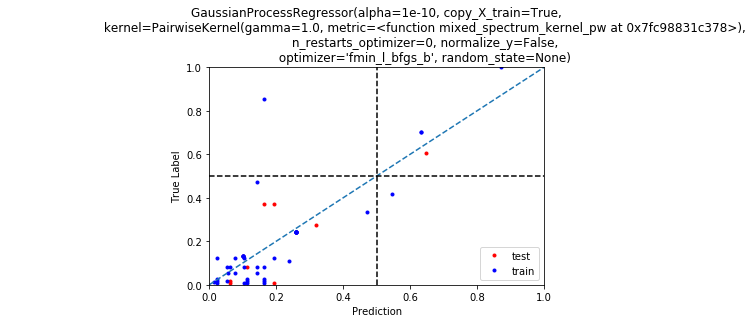

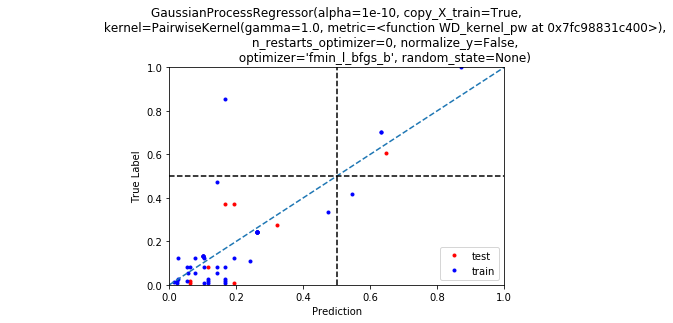

In [12]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

Text(0.5, 1.0, 'Test Scores')

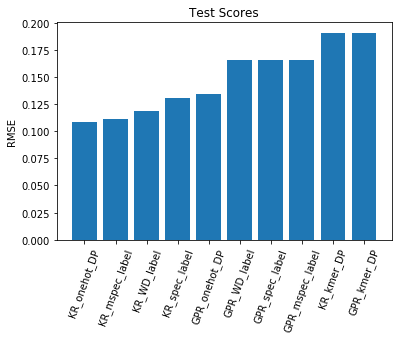

In [13]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')